# Deblurring Dataset

## Prerequisite
We need to blur image first

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import os
import random
from tqdm import tqdm
from image_function import *

Read image

In [2]:
origin_paths = []

for file in sorted(os.listdir('Dataset/DAPI/4x4')):
    if file != '.DS_Store':
        origin_paths.append('Dataset/DAPI/4x4/' + file)

print(origin_paths[0:5])

['Dataset/DAPI/4x4/1H_Nrf2_No_ADT_1_DAPI_0_0.png', 'Dataset/DAPI/4x4/1H_Nrf2_No_ADT_1_DAPI_0_1.png', 'Dataset/DAPI/4x4/1H_Nrf2_No_ADT_1_DAPI_0_2.png', 'Dataset/DAPI/4x4/1H_Nrf2_No_ADT_1_DAPI_0_3.png', 'Dataset/DAPI/4x4/1H_Nrf2_No_ADT_1_DAPI_1_0.png']


In [3]:
origin_paths[405][17:-4]

'1H_Nrf2_No_AP39_6_DAPI_1_1'

### Average Blur & Gaussian Blur preview

Black pixel: 119998
All pixel: 183457
Percentage: 65.40933297720993%


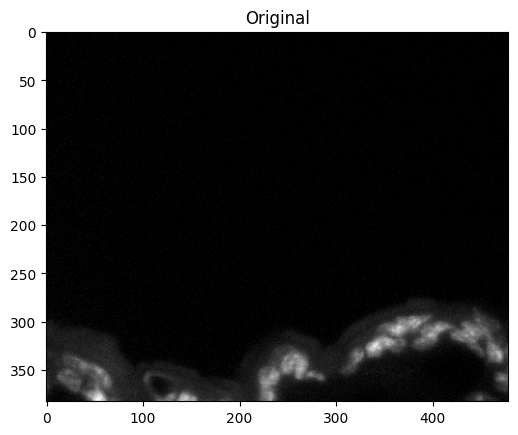

In [4]:
img = cv2.imread(origin_paths[0], 0)
n_px = img.shape[0]*img.shape[1]
n_black_px = np.sum(img == 0)
print('Black pixel: {}'.format(n_black_px))
print('All pixel: {}'.format(n_px))
print('Percentage: {}%'.format(n_black_px/n_px*100))
plot = plt.imshow(img, cmap='gray')
plt.title('Original')
plt.show()

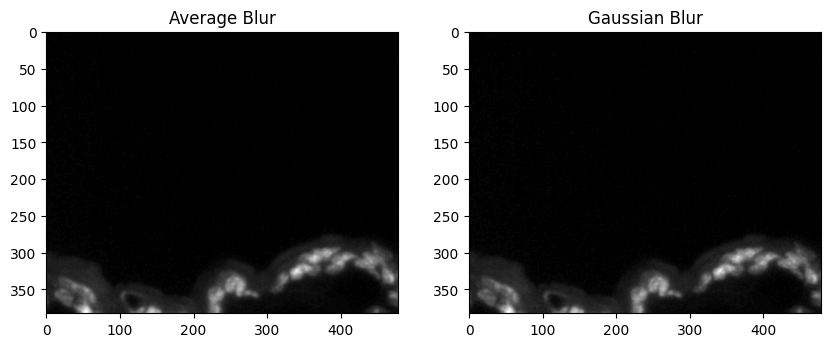

In [5]:
# Average blur, Gaussian blur
avg_blur = cv2.blur(img, (3,3))
gss_blur = cv2.GaussianBlur(img, (3,3), 0)

fig = plt.figure(10, (10,20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(avg_blur, cmap='gray')
ax.set_title('Average Blur')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(gss_blur, cmap='gray')
ax.set_title('Gaussian Blur')
plt.show()

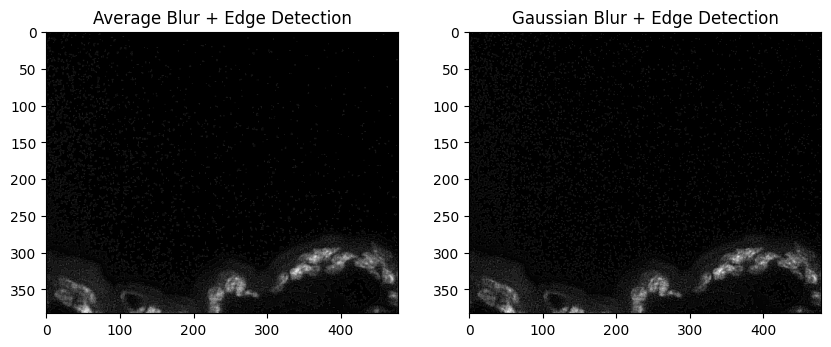

In [6]:
avg_sharp = sharpening(avg_blur, 1)
gss_sharp = sharpening(gss_blur, 1)

fig = plt.figure(10, (10,20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(avg_sharp, cmap='gray')
ax.set_title('Average Blur + Edge Detection')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(gss_sharp, cmap='gray')
ax.set_title('Gaussian Blur + Edge Detection')
plt.show()

### Create blur dataset

```
# run this cell if dont have 4x4_blur folder

!mkdir Dataset/DAPI/4x4_blur
!mkdir Dataset/DAPI/4x4_edge_detection
```

In [7]:
for path in tqdm(origin_paths):
    img = cv2.imread(path, 0)
    n_px = img.shape[0]*img.shape[1]
    n_black_px = np.sum(img == 0)
    if n_black_px/n_px*100 < 100:
        gss_blur = cv2.GaussianBlur(img, (5,5), 0)
        gss_sharp = sharpening(gss_blur, 1)

        img_name = path[17:-4]
        gss_path = 'Dataset/DAPI/4x4_blur/' + img_name + '_gssblur.png'
        sharp_path = 'Dataset/DAPI/4x4_edge_detection/' + img_name + '_edgedetection.png'
        
        cv2.imwrite(gss_path, gss_blur)
        cv2.imwrite(sharp_path, gss_sharp)

print(len(os.listdir('Dataset/DAPI/4x4_blur')))
print(len(os.listdir('Dataset/DAPI/4x4_edge_detection')))

100%|██████████| 3152/3152 [00:16<00:00, 189.78it/s]

3153
3153


## 1. CNN
https://medium.com/mlearning-ai/image-deblurring-using-convolutional-autoencoders-deep-learning-project-tutorial-329f87a4c6ad 

### Prepare image

In [69]:
gssblur_paths = []
for file in sorted(os.listdir('Dataset/DAPI/4x4_blur')):
    if file != '.DS_Store':
        gssblur_paths.append('Dataset/DAPI/4x4_blur/' + file)

edgedetection_paths = []
for file in sorted(os.listdir('Dataset/DAPI/4x4_edge_detection')):
    if file != '.DS_Store':
        edgedetection_paths.append('Dataset/DAPI/4x4_edge_detection/' + file)

print(len(edgedetection_paths))
print(len(gssblur_paths))

3152
3152


### Preprocessing

Convert image to 224x224 and change to array float32/255

In [70]:
import tensorflow as tf
from tqdm import tqdm

clean_frame = []
for path in tqdm(edgedetection_paths):
    img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale', target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img).astype('float32')/255
    clean_frame.append(img)

clean_frame = np.array(clean_frame)

blur_frame = []
for path in tqdm(gssblur_paths):
    img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale', target_size=(256, 256))
    img = tf.keras.preprocessing.image.img_to_array(img).astype('float32')/255
    blur_frame.append(img)

blur_frame = np.array(blur_frame)

print(clean_frame.shape)
print(blur_frame.shape)

100%|██████████| 3152/3152 [00:06<00:00, 507.76it/s]


(3152, 256, 256, 1)
(3152, 256, 256, 1)


Split train test

In [71]:
from sklearn.model_selection import train_test_split

x = clean_frame
y = blur_frame
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train[0].shape)
print(y_train[0].shape)

(256, 256, 1)
(256, 256, 1)


In [ ]:
r = random.randint(0, len(clean_frame)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frame[r], cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blur_frame[r], cmap='gray')

### Generate Network

In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

In [ ]:
# Network Parameters
input_shape = (256, 256, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

#### Building Encoder

We will directly use the libraries in order to avoid the cumbersome hand computations. We will be building a stack of `Conv2D(64) - Conv2D(128) - Conv2D(256)`. The model is going to be having input shape `(512, 512, 1)` and kernel size equal to `3` and the Encoder will compress this shape to `(16, 16, 256)` and will further flatten this into a one dimensional array which will be the input for our Decoder.

In [ ]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

`K.int_shape()` here helps in converting a tensor into a tuple of integers. Instantiating the encoder model,

In [ ]:
for filters in layer_filters:
    x = Conv2D(
        filters=filters, kernel_size=kernel_size, strides=2, 
        activation='relu', padding='same'
        )(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

#### Building Decoder

Decoder model will be similar to the encoder model but it will be doing the reverse or opposite computations. We will first manually convert the one dimensional array from the encoder model to the shape `(16, 16, 256)` and then send it to the decoder to decode it back to `(512, 521, 1)` shape. So the stack here will be `Conv2DTranspose(256) - Conv2DTranspose(128) - Conv2DTranspose(64)`.

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(
        filters=filters, kernel_size=kernel_size, strides=2,
        activation='relu', padding='same'
        )(x)

outputs = Conv2DTranspose(
    filters=3, kernel_size=kernel_size, activation='sigmoid', 
    padding='same', name='decoder_output'
    )(x)

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

#### Building the Autoencoder Model
Now that we have our encoder and decoder models, we can combine them to finally build our Autoencoder Model.
```
Autoencoder Model = Encoder Model + Decoder Model
```
Instantiating the Autoencoder model,

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

**Last but not the least** </br>
Before training our model, there’s one last thing we need to do, choose the hyperparameters. I am choosing Loss function to be Mean Squared Error, Optimizer to be Adam, and evaluation metric to be Accuracy.
Now defining the learning rate reducer to reduce the learning rate if there’s no improvement in the metric,

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [ ]:
lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1), cooldown=0, patience=5,
    verbose=1,min_lr=0.5e-6
    )

callbacks = [lr_reducer]

### Training the model

In [ ]:
history = autoencoder.fit(
    blur_frame, clean_frame, validation_data=(blur_frame, clean_frame),
    epochs=50, batch_size=batch_size, callbacks=callbacks
    )

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

In [ ]:
for i in range(3):
    
    r = random.randint(0, len(clean_frame)-1)

    x, y = blur_frame[r],clean_frame[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)
    ax.set_title('Input')

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)
    ax.set_title('Ground Truth')

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)
    ax.set_title('Predicted Value')

## 2.Direct Deblurring
https://colab.research.google.com/drive/1Cp2DcN3d7R_ypHXVnMQVRsFbU9ne8fXH?usp=sharing

(383, 383)


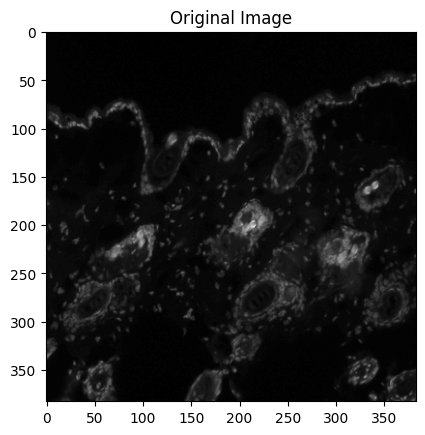

In [72]:
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageOps

#Load image
path = origin_paths[15]
path = 'Immunofluorescence images/DAPI/1H_Nrf2_No_ADT_1_DAPI.tif'
img = Image.open(path)
img = ImageOps.grayscale(img)
img = img.resize((383,383))
img = np.asarray(img)
print(img.shape)

plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

a function to blur the image.

In [73]:
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftshift
import numpy as np

def blur_filter(n,width=5):
    """Returns FFT of out of focus blur filter

    Args:
        n: dimensions of each side of the image
        width: Width of the out of focus filter
    
    Returns:
        G: Fourier transform of filter
    """

    x,y = np.mgrid[:n,:n]
    g = (x-n/2)**2 + (y-n/2)**2 < width**2
    g = g/np.sum(g)
    return fft2(fftshift(g)).real

def blur(f,G):
    """Blurs image f with filter G

    Args:
        f: image to blur
        G: Filter 

    Returns:
        Blurred image
    """
    return ifft2(G*fft2(f)).real

Deblurring

(383, 383)


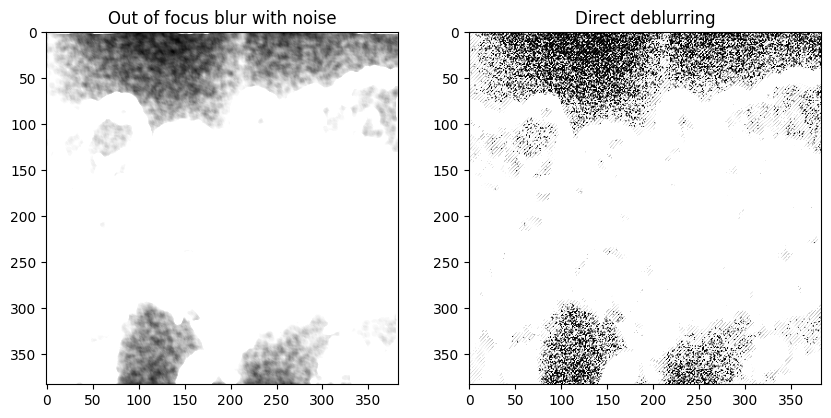

In [75]:
#First get a blur filter
G = blur_filter(img.shape[0],width=3)

#Blur the image
img_blurred = blur(img,G)

#Add noise
sigma = 1e-5 #Try sigma=0 first, and then try sigma > 0 to add noise
img_blurred = img_blurred + sigma*np.random.randn(img.shape[0],img.shape[1])

#Show blurred and noisy image
fig = plt.figure(10, (10,20))
ax = fig.add_subplot(1,2,1)
ax.imshow(img_blurred,cmap='gray',vmin=0,vmax=1)
ax.set_title('Out of focus blur with noise')

#Deblur the image and imshow
img_deblurred = ifft2(fft2(img_blurred)/G).real
print(img_deblurred.shape)
ax = fig.add_subplot(1,2,2)
ax.imshow(img_deblurred,cmap='gray',vmin=0,vmax=1)
ax.set_title('Direct deblurring')
plt.show()